# Projet 3 : Analyse de séquences génomiques
# 2 Préliminaires : données et lecture des fichier
## 2.1 - 2.2 : Code fourni

In [1]:
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import random

#Définition des nucléotides
nucleotide = {'A':0,'C':1,'G':2,'T':3}
nucleotide_indetermine = {'A':0,'C':1,'G':2,'T':3,'N':-1}

def decode_sequence(sequence):
    inv_nucleotide = {v:k for k, v in nucleotide_indetermine.items()}
    to_str = ""
    for i in sequence:
        if(i in inv_nucleotide):
            to_str += inv_nucleotide[i]
        else:
            to_str += 'N'
    return to_str
    

def encode_sequence(string):
    to_list = []
    for base in string:
        if(base in nucleotide_indetermine):
            to_list.append(nucleotide_indetermine[base])
    return to_list

def read_fasta(fasta_filepath):
    fasta_file = io.open(fasta_filepath, 'r')
    current_sequence = ""
    sequences_dict = {}
    for line in fasta_file.readlines():
        if(line[0] == '>'):
            current_sequence = line
            sequences_dict[line] = []
        else:
            for nucl in line:
                if(nucl in nucleotide_indetermine):
                    sequences_dict[current_sequence].append((int) (nucleotide_indetermine[nucl]))

    return sequences_dict
    
def nucleotide_count(sequence):
    count = [0 for k in nucleotide]
    for nucl in sequence:
        if(nucl >= 0):
            count[nucl] += 1
    return count

def nucleotide_frequency(sequence):
    count = [0 for k in nucleotide]
    n_nucl = 0.
    for nucl in sequence:
        if(nucl >= 0):
            count[nucl] += 1
            n_nucl += 1.
    return count/(np.sum(count))


## 2.3 - 2.4 : 

In [2]:
def logproba(liste_entiers,m):
    total = 0
    for lettre in liste_entiers:
        total+= math.log(m[lettre])
    return total

def logprobafast(m):
    summ = sum(m)
    tmp = [i / summ for i in m]
    return sum([math.log(tmp[i])*m[i] for i in range(len(m))])
    # Pour chaque tpye de nucléotide, on calcule sa proba et on la multiplie par son nombre d'occurences
    # On fait ensuite la somme des logprobas de chaque type de nucléotide
  

# 3 Annotation des régions promoteurs
## 3.1 Description empirique, préliminaires
### 3.1.1 : 

In [3]:
def code(m,k):
    """
    La première lettre d'une séquence de taille k a un poids de 4^k
    La suivante a un poids de 4^(k-1) le résultat est somme(lettres*poids)
    """
    i = k-1
    res = 0
    for lettre in m:
        res += lettre * (4 ** i)
        i -= 1
    return res
    
def inverse_code(i,k):
    res = []
    for ind in range(k-1,-1,-1):
        res.append(i // (4**ind))
        i = i % (4**ind)
    return res
    
def compte_occurences_mots(sequence,taille):
    resTmp = dict()
    for i in range(len(sequence)-taille+1): 
        # Pour chaque emplacement du début de la séquence au dernier emplacement disponible pour placer un mot de taille 'taille'
        sousSeq = code(sequence[i:i+taille],taille)
        # On isole le mot sans sousSeq puis on actualise le dictionnaire
        if not sousSeq in resTmp.keys():
            resTmp[sousSeq] = 1
        else:
            resTmp[sousSeq] += 1 
    res = dict()
    # Les clés du dictionnaire sont les codes des séquences, on déplace donc les valeurs dans un dictionnaire
    # contenant les clés sous forme de séquences de nucléotides (ex : "AT","TCGA")
    for k in resTmp.keys():
        lTmp = inverse_code(k,taille)
        buff = decode_sequence(lTmp)
        res[buff] = resTmp[k]
    return res

### 3.1.2

In [4]:
def comptage_attendu(freq,taille,longueur):
    res = dict()
    # Pour chaque mot de longueur 'taille' disponible dans un alphabet de 4 lettres 
    for i in range(4**taille):
        resTmp = 1.0
        tmp1 = i
        for j in range(taille-1,0-1,-1):
            tmp2 = tmp1%4
            tmp1 = tmp1//(4**j)
            resTmp = resTmp * freq[tmp2]
            # On calcule la probabilité du  mot 
        buff = decode_sequence(inverse_code(i,taille))
        res[buff] = resTmp * (longueur - taille +1)
        # On ajoute cette probabilité dans un dictionnaire construit comme le précédent
    return res

### 3.1.3

In [5]:
def affGraph2D(sequence,taille):
    nb_attendu = comptage_attendu( nucleotide_frequency(sequence) , taille, len(sequence)) 
    nb_obtenu =  compte_occurences_mots(sequence,taille)
    
    listeEtt = []
    listeAbs = []
    listeOrd = []
    for i in nb_attendu.keys():
        if i in nb_obtenu.keys():
            listeAbs.append(nb_obtenu[i])
        else:
            listeAbs.append(0)
        listeOrd.append(nb_attendu[i])
        listeEtt.append([i,listeAbs[-1],listeOrd[-1]])
        
        
    listeTruc = range(max(0,(int) (min(listeOrd)-5)),(int) (max(listeOrd)+5))
    plt.plot(listeTruc,listeTruc)
    
    plt.scatter(listeAbs,listeOrd)
    for i in listeEtt:
        plt.annotate(i[0],(i[1],i[2]))
    plt.show()
    print("A gauche : sous représenté \nA droite : sur représenté")
    
def affFichier(file,taille):
    l = []
    for v in read_fasta(file).values():
        l+=v
    affGraph2D(l,taille)


décrire ici comment on s'y prend

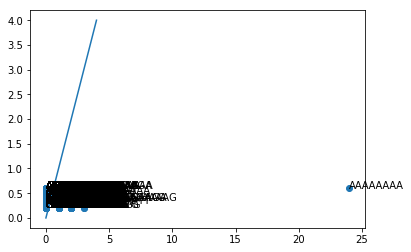

A gauche : sous représenté 
A droite : sur représenté


In [16]:
affFichier('regulatory_seq_PHO.fasta',2)

## 3.2 Simulation de séquences aléatoires
### 3.2.1

In [7]:
def simule_sequence(lg,m):
    res = []
    for i in range(lg):
        r = random.random()
        # en python, le cast en entier d'un booleen est 0 ou 1, cette ligne permet de générer un nombre entre 0 et 3 
        # en respectant les probabilités imposées
        res.append((int)(r >= m[0]) +(int)(r >= m[0]+m[1]) +(int)(r >= m[0]+m[1]+m[2]))
    return res

### 3.2.2

In [8]:
moy_ecarts = 0
for i in range(1000):
    freq = []
    for i in range(4):
        freq.append(random.random()+0.1)
    sumfreq = sum(freq)
    for i in range(4):
        freq[i] /= sumfreq
    simul = compte_occurences_mots(simule_sequence(1000,freq),1)
    attendu = comptage_attendu(freq,1,1000)
    dic = ["A","C","G","T"]
    a = [abs(simul[i] - attendu[i]) for i in dic]
    moy_ecarts+=sum(a)
print(moy_ecarts/4000)
       
    

10.32365492567934


### 3.2.3

In [9]:
def estimProbaEmpirique(longueur,mot,n=1):
    cpt = 0
    nb = 1000
    motConverti = encode_sequence(mot)
    if len(motConverti) > longueur:
        print('mot recherché trop long')
        return 
    for i in range(nb):
        freq = []
        for i in range(4):
            freq.append(random.random())
        sumfreq = sum(freq)
        for i in range(4):
            freq[i] /= sumfreq
        dico = compte_occurences_mots(simule_sequence(longueur,freq),len(motConverti))
        if not mot in dico.keys():
            continue
        elif dico[mot] >= n:
            cpt+=1
    return cpt/nb

### 3.2.4

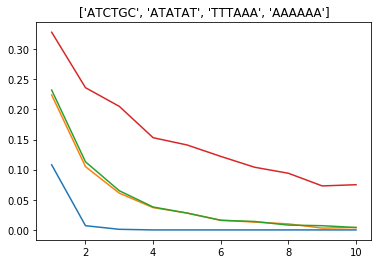

199.37507510185242


In [41]:
def histo(listeMots,n=10):
    plt.subplot()
    for i in listeMots:
        listeHisto = []
        for j in range(1,n+1):
            listeHisto.append(estimProbaEmpirique(1000,i,j)) 
        plt.plot(range(1,n+1),listeHisto)
    plt.title(listeMots)
    plt.show()
    return
import time
temps = time.time()
histo(["ATCTGC","ATATAT","TTTAAA","AAAAAA"])
print(time.time() - temps)

### 3.2.5
Répondre ici

## 3.3 Modèles de dinucléotides et trinucléotides
### 3.3.1
Répondre ici

### 3.3.2

In [32]:
def estimTableProbas(dicoComptage):
    table1 = [[0]*4,[0]*4,[0]*4,[0]*4]
    total = 0
    for k in dicoComptage.keys():
        l1 = encode_sequence(k)
        table1[l1[0]][l1[1]] += dicoComptage[k]
        total += dicoComptage[k]
    return [[ table1[i][j] / sum(table1[i]) for j in range(len(table1[i]))] for i in range(len(table1))]
# ligne 0 : liste des probas que un A soit suivi par chaque lettre    
# estimTableProbas(compte_occurences_mots([random.randint(0,3) for i in range(1000000)],2))

[[0.250133320502488,
  0.2508350073576879,
  0.24871791787457045,
  0.25031375426525365],
 [0.24852592341579124,
  0.2501764107879682,
  0.2514481631351287,
  0.2498495026611119],
 [0.2487890285384606,
  0.2512009551549923,
  0.24939401345390294,
  0.2506160028526441],
 [0.2501558927457909,
  0.251131221719457,
  0.2488048222822698,
  0.2499080632524823]]

### 3.3.3

In [26]:
def simule_sequence_dinucl(longueur,tableProba):
    # on peut utiliser uniquement la table car il est possible de retrouver les probas globales avec
    probaInit = [sum([tableProba[i][j] for j in range(len(tableProba[i]))]) for i in range(len(tableProba))]
    res = simule_sequence(1,probaInit)
    for i in range(longueur-1):
        res+= simule_sequence(1,tableProba[res[-1]])
    return res

# simule_sequence_dinucl(100,[[0,1,0,0],[0,0,1,0],[0,0,0,1],[1,0,0,0]])
# genere 100 nucléotides dans l'ordre 0,1,2,3,0...

### 3.3.4

In [13]:
# Cette proba est : (probaGlobaleNucl0 * probaCondNucl1 * probaCondNucl2 ... )
def calculProbaMot(sequence,mot):
    table1 = estimTableProbas(compte_occurences_mots(sequence,2))
    motCode = encode_sequence(mot)
    proba = sum([table1[motCode[0]][j] / len(table1) for j in range(len(table1[motCode[0]]))])
    for i in range(1,len(motCode)):
        proba *= table1[motCode[i]][motCode[i-1]]
    return proba

### 3.3.5

Le nombre d'occurences attendues pour ce mot se trouve de manière analogue au nombre d'occurences sans le modèle de dinucléotides : p[mot] * nombre d'emplacements possibles

### 3.3.6
Répondre ici

### 3.3.7
Répondre ici

## 3.4 Probabilités de mots
### 3.4.1
On peut considérer que pour une séquence de longueur $l$ et un mot $w$ de longueur $k$, le mot $w$ a $\frac{l}{k}$ emplacements possibles pour apparaître. On obtient alors une loi $B(p[w],\frac{l}{k})$.

### 3.4.2
L'approximation peut être une loi de Poisson de paramètre : $\lambda = p[w] * \frac{l}{k} $

Ainsi,$ p(w=n) = \frac{\lambda^k}{k!}e^{-\lambda} $

### 3.4.3
Répondre ici

### 3.4.4

In [14]:
"""

"""

'\n\n'

KeyboardInterrupt: 

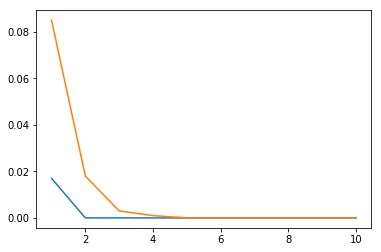

In [54]:
def histo2(listeMots,n=10):
    plt.subplot()
    for i in listeMots:
        listeHisto = []
        for i in range(4):
            tableProba.append([random.random() for i in range(4)])
            tableProba[-1] = [tableProba[-1][j] / sum(tableProba[-1]) for j in range(4)]
        probaMot = 1
        for i in range(len(i)):
            
        for j in range(1,n+1):
            tableProba = []
            
            listeHisto.append() 
        plt.plot(range(1,n+1),listeHisto)
    plt.title(listeMots)
    plt.show()
    return

calculProbaMot(simule_sequence_dinucl(longueur,tableProba))

import time
temps = time.time()
histo2(["ATCTGC","ATATAT","TTTAAA","AAAAAA"],10)
histo(["ATCTGC","ATATAT","TTTAAA","AAAAAA"],10)
print(time.time() - temps)